# SSCD Training Protocol

The Salmon Scale Circuli Detector (SSCD) system consists of two separate object detection models, working sequentially: the focus detector and the circulus detector. This notebook provides a general protocol for training each detector, based on the steps taken during the development of the SSCD tool. The protocol should be particularly useful if/when [currently expected performance][1] of the SSCD deteriorates, and therefore retraining one/both detectors becomes a requirement.

Both detectors are based on the YOLOv3 (*You Only Look Once*) algorithm, a Convolutional Neural Network (CNN) purposefully built for the detection of objects in images. Specifically:
- the focus detector is a YOLOv3 network trained to locate the scale's center from digital images comprising the whole scale.
- the circulus detector is a YOLOv3 network trained to locate circuli bands from transect images cropped from the original scale image. Importantly, these transect images are expected to be radials from the scale's focus.

The YOLOv3 models are implemented in Tensorflow 2, based on the code available in [this repository][2]. The original the code, which restricted CNN's input layer to a square shape, was modified to allow the input layer to accept customized rectangular shapes. This alteration made predictions on rectangular transect images achievable at higher resolutions for considerably lower computational memory demands, crucially improving the accuracy of the circulus detector.

Some general procedural comments regarding this protocol:

- Original training was performed using GPU parallelization (NVIDIA GeForce GTX 1080 with 8GB dedicated RAM). While not crucial, GPU acceleration is desirable for practicable training times. 

- For illustrative and portability purposes, the protocol is applied to a subsample of dataset used in the original development, which comprised 1030 scale images and 817 transect images. 

<!-- - The example dataset is not shipped in the SSCD repository and therefore needs to be downloaded (see below). -->

- The default directory to store data and outputs (`c:/scale_analysis/`) is optional and can be modified as per user's preferences. Naturally, changes to the default data directory will need to be propagated to the rest of the code accordingly.

[1]: ./sscd_evaluate.md#evaluation-metrics-on-test-set-on-latest-training
[2]: https://github.com/zzh8829/yolov3-tf2

### Set up workspace

Let's first start with setting up the working session. 

**Attention: The next chunk of code must be run every time this notebook is launched**

In [8]:
# import required modules
import os
from zipfile import ZipFile
from sscd_libs.helpers import download_url
from sscd_libs.data_processing import (
    images_tiff_to_jpeg,
    generate_label_map
)
from tools.visualize_TFrecord import visualize_tf
import shutil
import pandas as pd

# Set up working directory 
if not 'notebookDir' in globals():
    notebookDir = os.path.dirname(os.getcwd())
os.chdir(notebookDir)

# useful configuration to allow for path auto-completion (`Tab` key)
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

### Download and unzip example data

In [3]:
# create data directory
data_dir = "c:/scale_analysis"
os.makedirs(data_dir, exist_ok = True)

# A/N: secret handshake to dowload a file from dropbox - change final digit from "0" to "1" (i.e. "...?dl=0" to "...?dl=1") in link generated by dropbox
data_url = "https://www.dropbox.com/s/fpj1svas8xgz02d/sscd_training_example_data.zip?dl=1"

# specify path to file comprising the downloaded data
zip_path = os.path.join(data_dir, "sscd_training_example_data.zip")

# Download zip file with example data (1.3GB)
download_url(url=data_url, save_filepath=zip_path)

In [9]:
# Unzip data
with ZipFile(zip_path, 'r') as zipObj:
   # Extract all the contents of zip file in specified directory
   zipObj.extractall(data_dir)
    
# Delete zip file
os.remove(zip_path)

# 1. Focus Detector Training

In this section we go through the main steps for training the YOLOv3 model to detect the scale's focus on digital images of scales. Starting with the data preparation stage, we then move on to the actual training stage followed by the evaluation step.

## 1.1. Data Preparation

The chosen YOLOV3 implementation requires data to be formatted as [TFRecord][1] - Tensorflow's favoured format for efficient data storage, reading/writing and serialization. In this case, data consists of digital images of scales and associated annotation files containing coordinates of bounding boxes delimiting the scale focus. Furthermore:

- Original scale images are in TIF format, which is not supported by TFRecords. Therefore, original image files must converted to JPGs.

- *[labelImg][2]* is the graphical annotation tool recommended for labeling images. 

- Annotations in each scale should be saved as XLM files in  PASCAL VOC format.

<!-- - Images of scales without a clear focus due to "natural causes" should be excluded from the analysis. -->

[1]: https://www.tensorflow.org/tutorials/load_data/tfrecord
[2]: https://github.com/tzutalin/labelImg

### 1.1.1. Convert scale images from TIF to JPG

In [3]:
# directory path to tif images
scales_tif_dir = "c:/scale_analysis/sscd_training_example_data/focus_detection/scale_images_tif/"

# create directory to take converted jpg images
scales_jpg_dir = "c:/scale_analysis/focus_detection/inputs/scales_jpg/"
os.makedirs(scales_jpg_dir, exist_ok=True)

images_tiff_to_jpeg(scales_tif_dir, scales_jpg_dir)

100%|###################################################################################| 50/50 [00:02<00:00, 17.08it/s]


### 1.1.2. Labelling scale images

The next step is to label the scale images with the locations of the scale focus. Follow the instructions described [here][1] on how to launch and use *labelImg*, with the following changes:
- set images directory path to `c:/scale_analysis/focus_detection/inputs/scales_jpg/`
- set annotation files directory path to, for instance, `c:/scale_analysis/focus_detection/inputs/scales_anns/`
- specify the default label to `focus` 

**Note** : each bounding box should delimit the focus tightly, without covering it, with the center of the box aligned with the center of the focus.

[1]: ./sscd_evaluate.md#2-label-the-images

*In truly cooking-show fashion, "earlier prepared" annotation files for the example images are available in the data bundle downloaded earlier. So, here we can skip the tedious labelling process by simply copying the annotation files to the appropriate folder, as per the code below.*

In [17]:
# Copy "ready-made" annotation files to the appropriate training directory:
anns_dir_orig = "c:/scale_analysis/sscd_training_example_data/focus_detection/scale_annotations/"
anns_dir_dest = "c:/scale_analysis/focus_detection/inputs/scales_anns/"
# clean-up before copying 
shutil.rmtree(anns_dir_dest)
# copy all annotation files to destination directory
shutil.copytree(anns_dir_orig, anns_dir_final)

'c:/scale_analysis/focus_detection/inputs/scales_anns/'

### 1.1.3. Split dataset into training, validation and test subsets

In order to train, develop and evaluate the focus detector, the dataset (i.e. scale images and focus annotations) needs to be (randomly) split into 3 subsets:
- **Training set** (70% of the data): used to train competing model configurations
- **Validation set** (20%): for monitoring the training process to prevent model overfitting, and to evaluate and compare the performance of competing models
- **Test set** (10%): for testing the generalization power of the selected model on never-before-seen data.
  
We adopted the simple hold-out validation approach - i.e. all evaluations performed on a fixed validation set. The resulting size of the validation set (206 in original dataset) was deemed representative of the type of images and scale characteristics expected to be produced from salmon scale imaging (e.g. resolution, magnification, lighting, scale's orientation and framing, and scale's natural features).

> <ins>Note 1</ins>: There is no specific standard split ratio for subseting the dataset, and therefore a different split ratio could have been chosen. The common rule-of-thumb is to provide as much data as possible for the training, while retaining representative sets for evaluating and testing the model. 

<!-- > Note 2: K-fold cross-validation is an alternative to the hold-out set approach, but it was considered computationally too expensive to implement for what appeared to be well represented subsets.
 -->
> <ins>Note 2</ins>: Once the data splitting step is done, the test set **must** be kept apart from the training and model tuning processes to avoid overfitting caused by *information leaks* - the phenomenon by which information in non-training sets leak every time they are used to evaluate the model's performance during model selection and tuning (i.e. by *indirect* learning). Therefore, the model should not have access to **any** information contained in the test set, even indirectly, until it is used to test the final/best model. Otherwise, any measure of generalization power will be, almost certainly, flawed.




<!-- evaluate performance during model tuning


model training and tuning needs to start from scratch. An easy way to recognize

In order to get a sense of the level of information leakage occurred on the validation set, we can reshuffle the training and validation sets 



In [56]:
# Quick look at the arguments of the data-splitting program
%run "./tools/create_splits.py" --help

usage: create_splits.py [-h] --images_dir IMAGES_DIR --annotations_dir
                        ANNOTATIONS_DIR --output_dir OUTPUT_DIR
                        [--output_prefix OUTPUT_PREFIX] [--split SPLIT]

Splits image filenames (ID's) to use for training, validation and test sets

optional arguments:
  -h, --help            show this help message and exit
  --images_dir IMAGES_DIR
                        path to directory containing image files
  --annotations_dir ANNOTATIONS_DIR
                        path to directory containing annotation files
  --output_dir OUTPUT_DIR
                        path to directory where split files are stored
  --output_prefix OUTPUT_PREFIX
                        prefix to be used in output split files
  --split SPLIT         colon-separated triple of ratios to use for training,
                        validation, and testing (values should sum to 1.0).
                        Default is '0.6:0.2:0.2'


In [19]:
# Run data splitting
%run "./tools/create_splits.py"\
    --images_dir "C:/scale_analysis/focus_detection/inputs/scales_jpg/"\
    --annotations_dir "C:/scale_analysis/focus_detection/inputs/scales_anns/"\
    --output_dir "C:/scale_analysis/focus_detection/inputs/set_ids/"\
    --output_prefix "scales_"\
    --split "0.70:0.20:0.10"

A total of 50 image IDs were split into the following sets:
----------------------------------
Training set: 35 image IDs
Validation set: 10 image IDs
Testing set: 5 image IDs
----------------------------------


### 1.1.4. Generate TFRecord files

#### Create labels file

To generate TFRecord files, we first need to create a labels file (also referred to as classes file) - to map labels/classes of interest in the dataset into integers IDs, as per Tensorflow's requirements (integers are programmatically "cleaner" than strings). 

Label files take different formats depending on the implementation (e.g. as a protobuf file or a python dictionary). Here we use the simpler NAMES format, in which each label class is assigned to a new line.

In this case, we have one single label: "focus". 

In [29]:
# Specify label classes of interest
labels = ['focus']
labels_df = pd.DataFrame({"class" : labels})

# Specify filepath to NAMES label file to write to
label_names_file = "C:/scale_analysis/focus_detection/inputs/scales_label.names"

# write NAMES file
with open(label_names_file, 'w') as f:
    f.writelines(labels_df["class"].unique())

#### Training Set

In [54]:
# Help for TFRecords conversion program
%run  "./tools/convert_pascal_to_tfrecords.py" --help

usage: convert_pascal_to_tfrecords.py [-h] --images_dir str --annotations_dir
                                      str --split_image_ids_file str
                                      --output_file str --label_names_file str
                                      [--drop_difficult_ann {True,False}]

Converting PascalVOC xlm annotation files to TFRecords

optional arguments:
  -h, --help            show this help message and exit
  --images_dir str      path to directory containing image files
  --annotations_dir str
                        path to directory containing annotation files
  --split_image_ids_file str
                        path to file specifying image IDs on the split to be
                        converted
  --output_file str     path to TFRecord file output
  --label_names_file str
                        NAMES file with label names, one per line
  --drop_difficult_ann {True,False}
                        whether to drop annotations whose bounding boxes were
          

In [22]:
%run  "./tools/convert_pascal_to_tfrecords.py" \
    --images_dir "C:/scale_analysis/focus_detection/inputs/scales_jpg/"\
    --annotations_dir "C:/scale_analysis/focus_detection/inputs/scales_anns/"\
    --split_image_ids_file "C:/scale_analysis/focus_detection/inputs/set_ids/scales_train.txt"\
    --label_names_file "C:/scale_analysis/focus_detection/inputs/scales_label.names"\
    --output_file "C:/scale_analysis/focus_detection/inputs/tfrecords/scales_train.tfrecord"

INFO (2021-04-13 13:18:11): Class mapping loaded: {'focus': 0}
INFO (2021-04-13 13:18:11): Image list loaded: 35
100%|###################################################################################| 35/35 [00:01<00:00, 20.84it/s]
INFO (2021-04-13 13:18:14): Number of images included in TFRecord dataset: 35


#### Validation Set

In [23]:
%run  "./tools/convert_pascal_to_tfrecords.py" \
    --images_dir "C:/scale_analysis/focus_detection/inputs/scales_jpg/"\
    --annotations_dir "C:/scale_analysis/focus_detection/inputs/scales_anns/"\
    --split_image_ids_file  "C:/scale_analysis/focus_detection/inputs/set_ids/scales_valid.txt"\
    --label_names_file "C:/scale_analysis/focus_detection/inputs/scales_label.names"\
    --output_file "C:/scale_analysis/focus_detection/inputs/tfrecords/scales_valid.tfrecord"

INFO (2021-04-13 13:18:46): Class mapping loaded: {'focus': 0}
INFO (2021-04-13 13:18:46): Image list loaded: 10
100%|###################################################################################| 10/10 [00:00<00:00, 21.44it/s]
INFO (2021-04-13 13:18:46): Number of images included in TFRecord dataset: 10


#### Test Set

In [28]:
%run  "./tools/convert_pascal_to_tfrecords.py" \
    --images_dir "C:/scale_analysis/focus_detection/inputs/scales_jpg/"\
    --annotations_dir "C:/scale_analysis/focus_detection/inputs/scales_anns/"\
    --split_image_ids_file  "C:/scale_analysis/focus_detection/inputs/set_ids/scales_test.txt"\
    --label_names_file "C:/scale_analysis/focus_detection/inputs/scales_label.names"\
    --output_file "C:/scale_analysis/focus_detection/inputs/tfrecords/scales_test.tfrecord"

INFO (2021-04-13 13:19:54): Class mapping loaded: {'focus': 0}
INFO (2021-04-13 13:19:54): Image list loaded: 5
100%|#####################################################################################| 5/5 [00:00<00:00, 21.74it/s]
INFO (2021-04-13 13:19:55): Number of images included in TFRecord dataset: 5


### 1.1.5. Graphical check of generated TFRecords

Check if the TFRecords were generated correctly by plotting a random subsample of images and associated annotations, from one of the TFRecord sets.

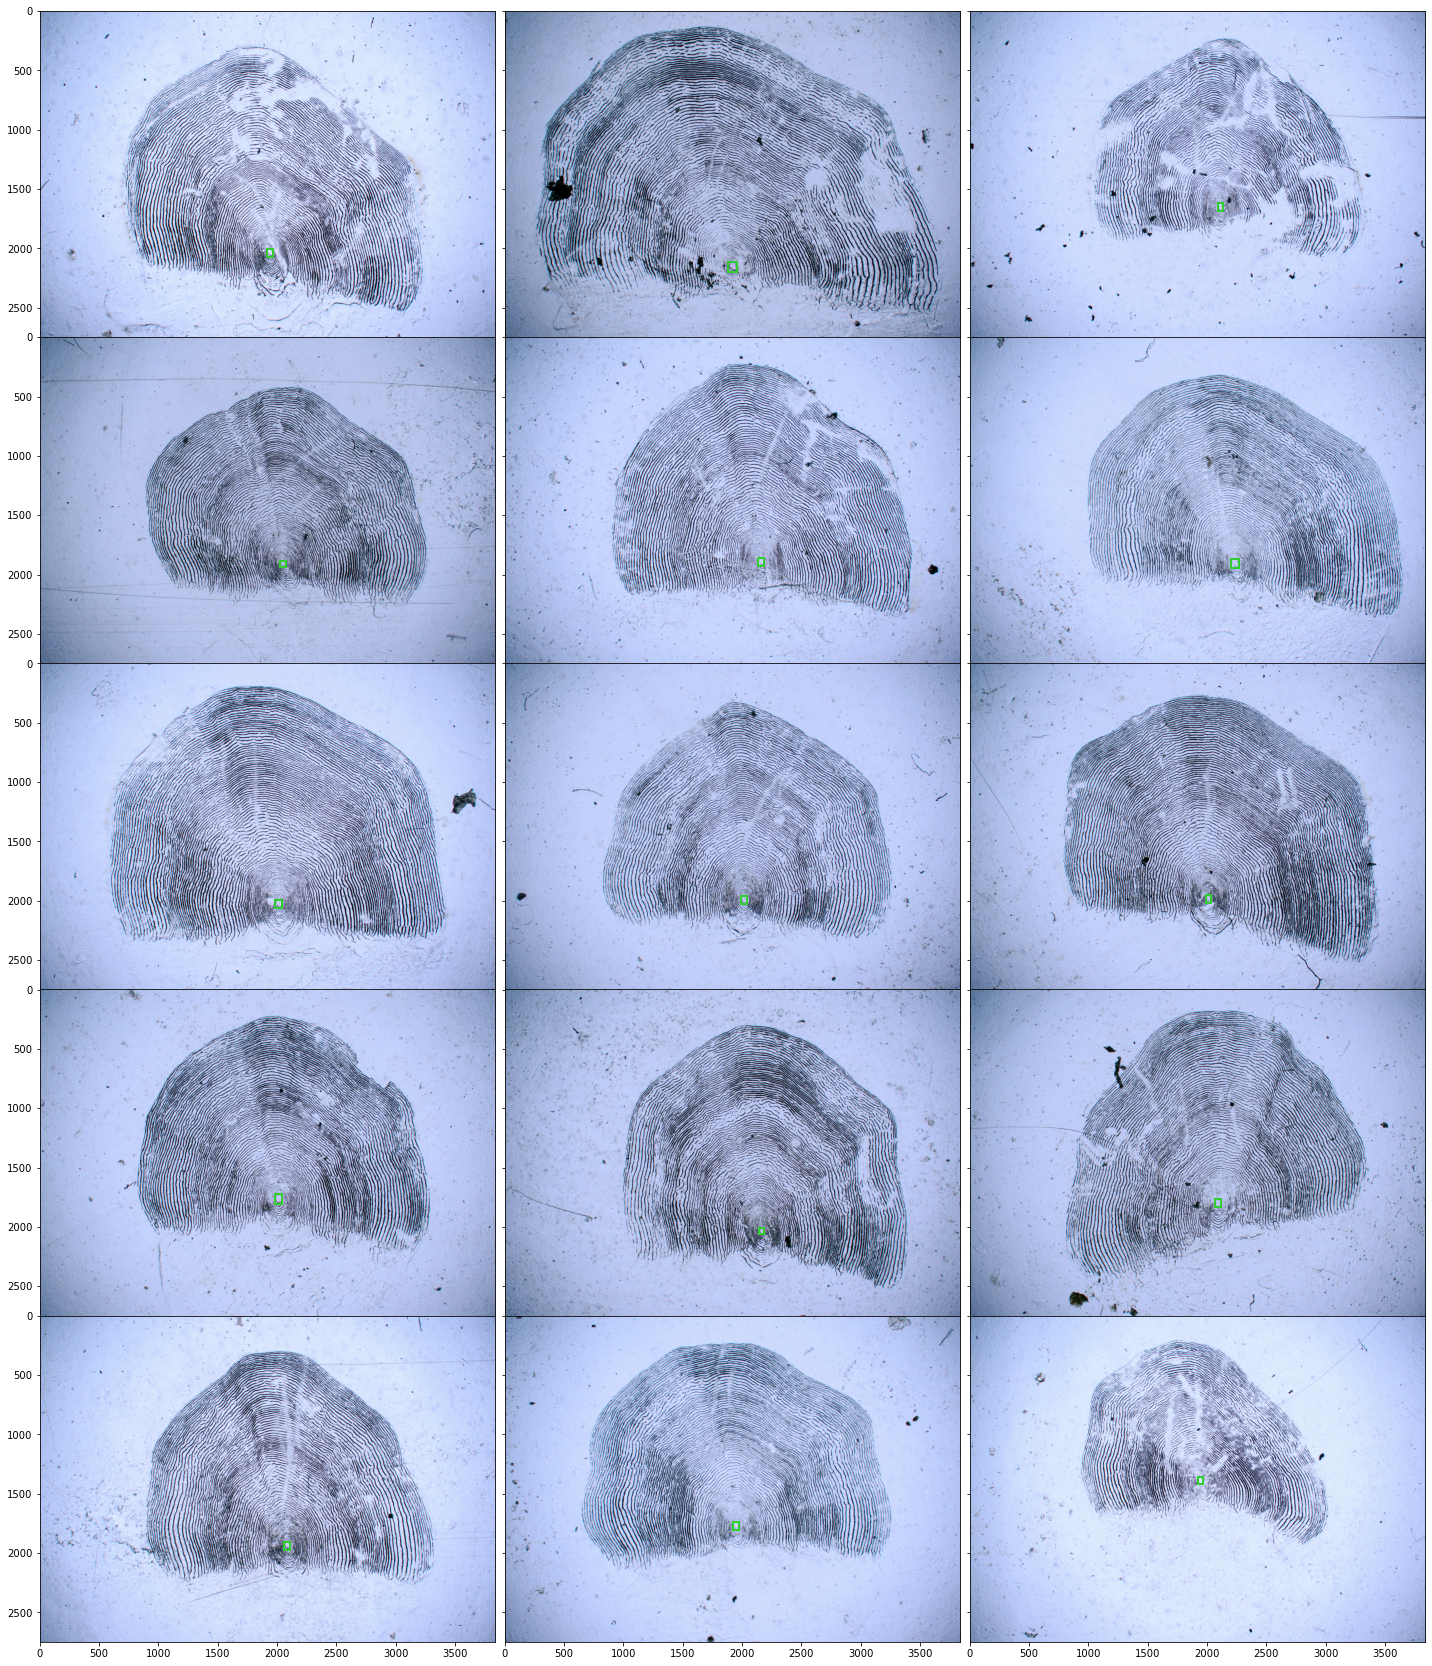

In [16]:
# random sample of instances in training set 
visualize_tf("C:/scale_analysis/focus_detection/inputs/tfrecords/scales_train.tfrecord", n_instances = 15, nrow = 5, ncol = 3, figsize=(25, 30))

## 1.2. Training the Focus Detector

Software and data preparation requirements should now be in place to start training/retraining the YOLOv3 model as a focus detector. 

Training follows a *transfer learning* approach, whereby a pre-trained network is reused or repurposed for a different task of interest. The underlying assumption is that the hierarchy of features learned from a large enough dataset can act as a generic model of the visual world.

The next section sets up the components needed for training with transfer learning.

<!-- The YOLOv3 implementation used here allows for a few training configuration options

There are a few options in terms of training configuration in the YOLO implementation under, the key ones being:
- learning rate
- ...

The original training of the focus detector was performed over a set of runs to experiment with the key configuration options described above, including:

In the original training The focus detector was developed over a few runs experimenting on input choices and network configurations


Only the training run producing the best model is provided here. A few of the things tried to improve performance include:
- Using the maximum possible input layer size for the GPU memory available (8GB of RAM)


options in implementation allows to choose different training regimes and hyperparameters...


loss profiles on training and validation datasets and guarding against overfitting (the point when model starts fitting noise instead of signal) -->

### 1.2.1 Set up transfer learning

YOLOv3 models are typically trained using transfer learning via feature-extraction. Convolutional weights from a feature-extractor network (called Darknet-53), trained on the ImageNet dataset (1.4 million labeled images with 1000 different object classes) are loaded into the YOLOv3 network before training starts. During training, the feature-extraction convolutional layers of YOLOv3 (a variant of Darknet-53) are kept frozen to extract generic features (e.g. edges, colors, textures, and higher-level combinations of those) from the new dataset, while the upper detection-tasked layers are trainable to combine lower-level features into more complex meaningful patterns.

<!-- Training follows a *transfer learning* approach, whereby a network pre-trained on a large dataset is reused or repurposed for a different task of interest. The underlying assumption is that the hierarchy of features learned from a large enough dataset can act as a generic model of the visual world. This portability of is particularly effective for small-data problems. 

YOLOv3 models are typically trained using transfer learning via feature-extraction, which consists of using features learned by a previous network to extract features from new samples. In this case, convolutional weights from a feature-extractor network (called Darknet-53), trained on the ImageNet dataset (1.4 million labeled images with 1000 different object classes), are loaded into the YOLOv3 network before training starts. Then, during training, the feature-extraction convolutional layers of YOLOv3 (a variant of Darknet-53) are kept frozen, while the (upper) detection-tasked layers are trainable. 
 -->

So, before training, we need to download the pre-trained weights and prepare them for YOLOv3.

In [11]:
# Download the pre-trained darknet weigths
# Create new folder for transfer learning files
os.makedirs("c:/scale_analysis/transfer_learning", exist_ok=True)
download_url("https://pjreddie.com/media/files/yolov3.weights", "c:/scale_analysis/transfer_learning/yolov3.weights")

In [19]:
# Convert the downloaded weights to checkpoint files, which can be later loaded into YOLOv3 for training
%run "./yolov3_tf2/convert.py"\
    --weights_file "c:/scale_analysis/transfer_learning/yolov3.weights"\
    --output_file "c:/scale_analysis/transfer_learning/checkpoints/yolov3.tf"

INFO 2021-04-30  12:58:40: model created
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_300 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_301 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_302 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_303 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_304 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_305 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_306 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_307 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_308 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_309 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_310 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_311 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_312 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_313 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_314 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_315 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_316 bn
INFO 2021-04-30  12:58:40: yolo_darknet/c

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_329 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_330 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_331 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_332 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_333 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_334 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_335 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_336 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_337 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_338 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_339 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_340 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_341 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_342 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_343 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_344 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_345 bn
INFO 2021-04-30  12:58:40: yolo_darknet/conv2d_346 bn
INFO 2021-04-30  12:58:40: y

In [31]:
608/32

19.0

### 1.2.2 Train YOLOv3

# 2. Circuli Detector Training

## 2.1 Circuli Data Processing

## 2.2 Training the Circuli Detector